### Finetuning

Hidden states are trained along with a classification head using a small labeled dataset. This allows hidden states to adapt to the dataset and achieve better performance on the dataset of interest. 

Finetuning a DistilBert model with emotions dataset

In [20]:
import numpy as np
import pandas as pd
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import Trainer, TrainingArguments
import torch
from datasets import load_dataset

from sklearn.metrics import accuracy_score, f1_score


In [21]:

num_labels=6
model_ckpt = 'distilbert-base-uncased'
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.w

Classification weights are not initialised, so the model needs to be trained for classification

Load emotions dataset

In [22]:
emotions = load_dataset('SetFit/emotion')

Using custom data configuration SetFit--emotion-e444b7640ce3116e
Found cached dataset json (/home/vivek/.cache/huggingface/datasets/SetFit___json/SetFit--emotion-e444b7640ce3116e/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51)


  0%|          | 0/3 [00:00<?, ?it/s]

In [23]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 16000
    })
    test: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 2000
    })
    validation: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 2000
    })
})

In [24]:
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=False)
    
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Loading cached processed dataset at /home/vivek/.cache/huggingface/datasets/SetFit___json/SetFit--emotion-e444b7640ce3116e/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51/cache-2a5326c6c3f4841d.arrow


  0%|          | 0/1 [00:00<?, ?ba/s]

Loading cached processed dataset at /home/vivek/.cache/huggingface/datasets/SetFit___json/SetFit--emotion-e444b7640ce3116e/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51/cache-4eed9c48a8c5fdbc.arrow


In [25]:
emotions_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    test: Dataset({
        features: ['text', 'label', 'label_text', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    validation: Dataset({
        features: ['text', 'label', 'label_text', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

Performance Metric

In [26]:
def compute_metrics(pred):
    
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1}

In [39]:
batch_size = 64
logging_steps = len(emotions_encoded['train'])//batch_size

model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(
                                    output_dir=model_name,
                                    num_train_epochs=3,
                                    learning_rate=2e-5,
                                    per_device_train_batch_size=batch_size,
                                    per_device_eval_batch_size=batch_size,
                                    weight_decay=0.01,
                                    evaluation_strategy='epoch',
                                    disable_tqdm=False,
                                    logging_steps=logging_steps,
                                    log_level='error'
                                    
                                )

In [37]:
(emotions_encoded['train'].select(range(100)))

Dataset({
    features: ['text', 'label', 'label_text', 'input_ids', 'attention_mask'],
    num_rows: 100
})

In [40]:
trainer = Trainer(model=model,
                 args=training_args,
                 compute_metrics=compute_metrics,
                 train_dataset=emotions_encoded['train'],
                 eval_dataset=emotions_encoded['validation'],
                 tokenizer=tokenizer)

trainer.train()

/home/vivek/.local/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 1.180893898010254, 'eval_accuracy': 0.62, 'eval_f1': 0.4975704225352112, 'eval_runtime': 1.5187, 'eval_samples_per_second': 65.845, 'eval_steps_per_second': 1.317, 'epoch': 1.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 1.0538822412490845, 'eval_accuracy': 0.63, 'eval_f1': 0.5056610470275067, 'eval_runtime': 1.482, 'eval_samples_per_second': 67.475, 'eval_steps_per_second': 1.35, 'epoch': 2.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.9980353713035583, 'eval_accuracy': 0.65, 'eval_f1': 0.5596842105263158, 'eval_runtime': 1.4057, 'eval_samples_per_second': 71.137, 'eval_steps_per_second': 1.423, 'epoch': 3.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.9427658319473267, 'eval_accuracy': 0.65, 'eval_f1': 0.5609577464788732, 'eval_runtime': 1.3777, 'eval_samples_per_second': 72.586, 'eval_steps_per_second': 1.452, 'epoch': 4.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.9211843609809875, 'eval_accuracy': 0.66, 'eval_f1': 0.5746666666666667, 'eval_runtime': 1.5994, 'eval_samples_per_second': 62.524, 'eval_steps_per_second': 1.25, 'epoch': 5.0}
{'train_runtime': 327.2929, 'train_samples_per_second': 15.277, 'train_steps_per_second': 0.244, 'train_loss': 1.0982325553894043, 'epoch': 5.0}


TrainOutput(global_step=80, training_loss=1.0982325553894043, metrics={'train_runtime': 327.2929, 'train_samples_per_second': 15.277, 'train_steps_per_second': 0.244, 'train_loss': 1.0982325553894043, 'epoch': 5.0})

Evaluation of the trained model: Confusion Matrix

Get predictions on validation set

In [41]:
preds_output = trainer.predict(emotions_encoded['validation'])
preds_output

  0%|          | 0/32 [00:00<?, ?it/s]

PredictionOutput(predictions=array([[ 1.7090542 , -0.60498106, -0.6843202 ,  0.22433458,  0.08855602,
        -0.88751745],
       [ 1.1857754 , -0.61272955, -0.695687  ,  0.3240202 ,  0.74435234,
        -0.65783906],
       [-0.66186744,  2.2353747 ,  0.7680528 , -1.0138999 , -0.60349184,
        -0.49983332],
       ...,
       [-0.8918657 ,  2.3773751 ,  0.74762636, -1.0503939 , -0.6029408 ,
        -0.3462072 ],
       [-0.86393595,  2.447637  ,  0.8352506 , -1.1255658 , -0.69377625,
        -0.49454224],
       [-0.92508554,  2.3268447 ,  0.6656499 , -1.0438763 , -0.7462544 ,
        -0.26178628]], dtype=float32), label_ids=array([0, 0, 2, ..., 1, 1, 1]), metrics={'test_loss': 0.9870486259460449, 'test_accuracy': 0.6715, 'test_f1': 0.6067521686594002, 'test_runtime': 27.2413, 'test_samples_per_second': 73.418, 'test_steps_per_second': 1.175})

In [42]:
preds_output.metrics

{'test_loss': 0.9870486259460449,
 'test_accuracy': 0.6715,
 'test_f1': 0.6067521686594002,
 'test_runtime': 27.2413,
 'test_samples_per_second': 73.418,
 'test_steps_per_second': 1.175}

In [47]:
y_preds = np.argmax(preds_output.predictions, axis=1)
y_valid = preds_output.label_ids

In [44]:
y_preds

array([0, 0, 1, ..., 1, 1, 1])

In [49]:
label_map = list(set(zip(emotions['train']['label'], emotions['train']['label_text'])))
label_map.sort(key= lambda pair: pair[0])
labels = [l[1] for l in label_map]
labels

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

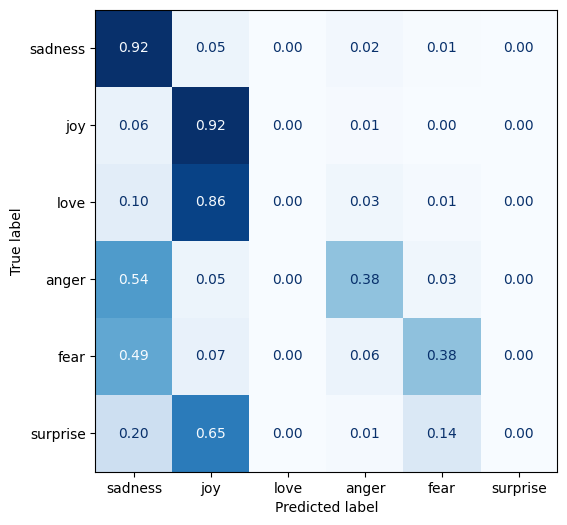

In [52]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_mat(y_true, y_pred, labels):

    cm = confusion_matrix(y_true, y_pred, normalize='true')
    fig, ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', values_format='.2f', ax=ax, colorbar=False)
    plt.show()


plot_confusion_mat(y_valid, y_preds, labels)